In [1]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random
from tensorflow.keras.applications.resnet50 import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, Model, preprocessing
from tensorflow.keras.layers import Conv2D, Concatenate, MaxPooling2D
from collections import Counter

In [2]:
random_seed = 42
np.random.seed(random_seed)

# Data import and split

In [3]:
train_data_dir = './data_split/train'
test_data_dir = './data_split/test'

img_size = (224, 224)
batch_size = 32

train_ds = preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.3,
    subset='training',
    seed=random_seed,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True, 
    crop_to_aspect_ratio=True
)

val_ds = preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.3,
    subset='validation',
    seed=random_seed,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True, 
    crop_to_aspect_ratio=True
)

test_ds = preprocessing.image_dataset_from_directory(
    test_data_dir,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    crop_to_aspect_ratio=True
)

class_names = train_ds.class_names

#train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
#val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
#test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

Found 1545 files belonging to 3 classes.
Using 1082 files for training.
Found 1545 files belonging to 3 classes.
Using 463 files for validation.
Found 517 files belonging to 3 classes.


# Evaluation methods

In [4]:
def predict_test_data(model, test_data):
    true_labels = []
    pred_labels = []
    
    for images, labels in test_data:
        preds = model.predict(images)
        true_labels.extend(np.argmax(labels.numpy(), axis=1))
        pred_labels.extend(np.argmax(preds, axis=1))
    return true_labels, pred_labels

In [5]:
def make_classification_report(true_labels, pred_labels):
    print(classification_report(true_labels, pred_labels, target_names=class_names))

In [6]:
def make_confusion_matrix(true_labels, pred_labels):
    m = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(m, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

In [8]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

# Base model

Our base model is a plain ResNet50 model which is initialized with random weights and therefore has no prior knowledge of any images.

In [9]:
# Build model from scratch (random init)
base_model = ResNet50(include_top=True, weights=None, input_shape=(224, 224, 3), classes=len(class_names)) # include_top=True adds the classification layer

base_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [10]:
history = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.8064 - loss: 2.1107 - val_accuracy: 0.9071 - val_loss: 96.3861
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9003 - loss: 0.3771 - val_accuracy: 0.9071 - val_loss: 23.3998
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.8945 - loss: 0.3882 - val_accuracy: 0.9071 - val_loss: 0.3446
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.9113 - loss: 0.3096 - val_accuracy: 0.9050 - val_loss: 0.3994
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.9122 - loss: 0.2866 - val_accuracy: 0.5400 - val_loss: 4.4429
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.9020 - loss: 0.3305 - val_accuracy: 0.8920 - val_loss: 0.4228
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.8956 - loss: 0.3199 - val_accuracy: 0.9050 - val_loss: 0.7528
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9029 - loss: 0.3421 - val_accuracy: 0.8618 - val_

In [11]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


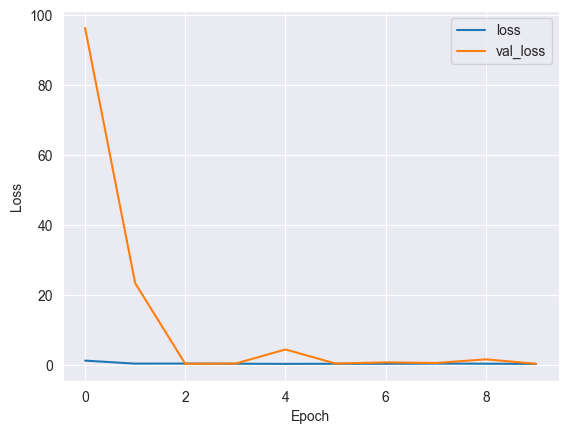

In [12]:
plot_loss(history)

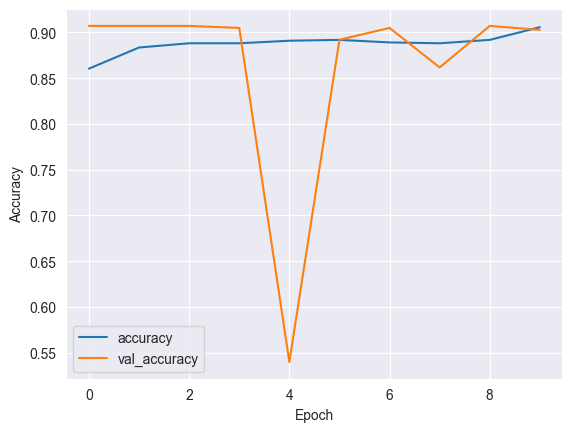

In [13]:
plot_accuracy(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

         Ant       0.67      0.11      0.19        37
        Bear       0.00      0.00      0.00        17
         Bee       0.90      1.00      0.95       463

    accuracy                           0.90       517
   macro avg       0.52      0.37      0.38       517
weighted avg     

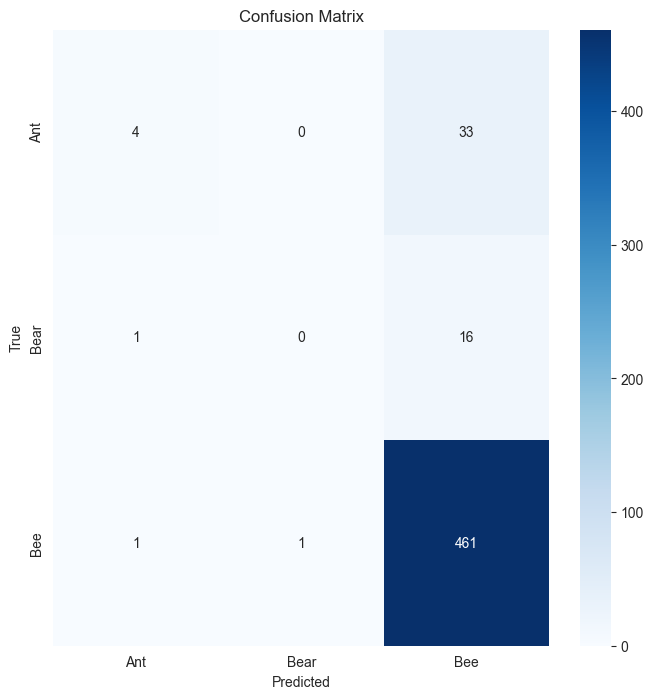

In [14]:
y_true, y_pred = predict_test_data(base_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)

In [15]:
base_model.save('./models/PlainResNet50.keras')

# Pretrained model

Use the weights that were obtained by training on the imagenet dataset. All other parameters stay the same to really compare the two models.

In [16]:
def build_pretrained_model():
    base_architecture = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), classes=len(class_names), pooling='avg') # pooling None, avg or max?
    
    base_architecture.trainable = False # no need to re-train these layers
    
    model = tf.keras.models.Sequential()
    model.add(base_architecture)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


pretrained_model = build_pretrained_model()
pretrained_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [17]:
pretrained_history = pretrained_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10 # train until converging? accuracy is already good
)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 872ms/step - accuracy: 0.8573 - loss: 0.5834 - val_accuracy: 0.9827 - val_loss: 0.0584
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 830ms/step - accuracy: 0.9840 - loss: 0.0441 - val_accuracy: 0.9849 - val_loss: 0.0443
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 824ms/step - accuracy: 0.9935 - loss: 0.0124 - val_accuracy: 0.9892 - val_loss: 0.0410
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 823ms/step - accuracy: 0.9985 - loss: 0.0038 - val_accuracy: 0.9892 - val_loss: 0.0420
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 822ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9849 - val_loss: 0.0414
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 835ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9892 - val_loss: 0.0391
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 828ms/step - accuracy: 1.0000 - loss: 9.3628e-04 - val_accuracy: 0.9892 - val_loss: 0.0384
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 822ms/step - accuracy: 1.0000 - loss: 6.0370e-04 - 

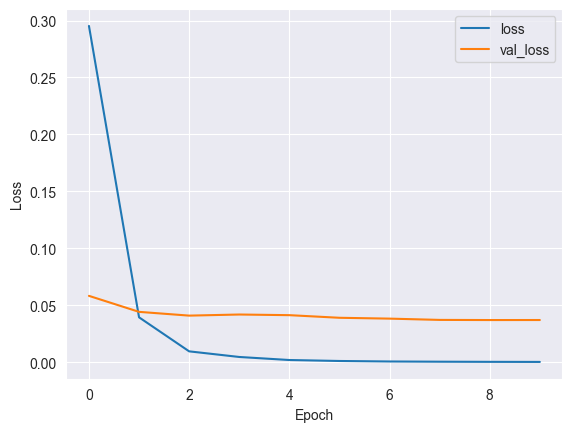

In [18]:
plot_loss(pretrained_history)

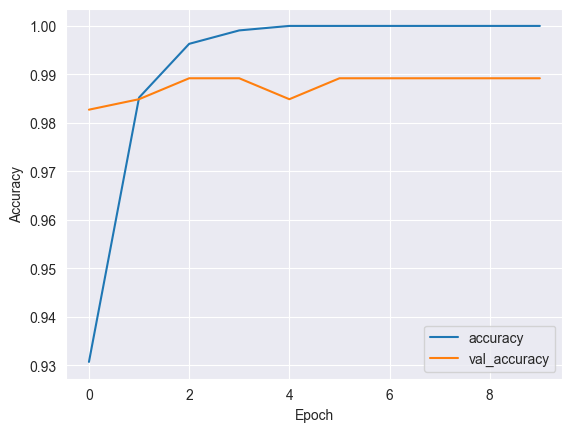

In [19]:
plot_accuracy(pretrained_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

         Ant       0.94      0.84      0.89        37
        Bear       0.85      1.00      0.92        17
         Bee       0.99      0.99      0.99       463

    accuracy                           0.98       517
   macro avg       0.93      0.94      0.93       517
weighted avg     

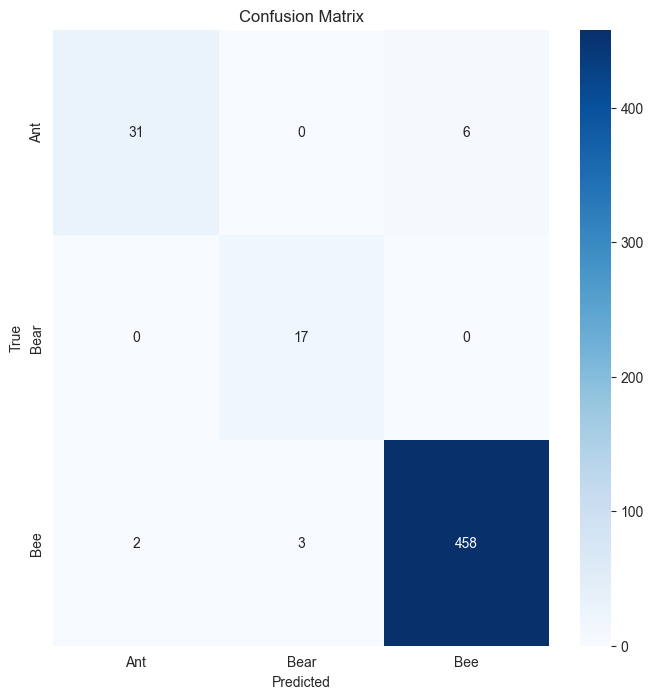

In [20]:
y_true, y_pred = predict_test_data(pretrained_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)
pretrained_model.save('./models/PretrainedResNet50.keras')

# Data Augmentation

In [21]:
def visualize(original, augmented, title):
    fig = plt.figure(figsize=(8, 4))
    plt.title(title)

    def prepare(img):
        # Ensure float32 and normalize only if needed
        if img.dtype != tf.uint8:
            img = tf.clip_by_value(img, 0, 255)
            img = tf.cast(img, tf.uint8)

        img = img.numpy()

        if img.shape[-1] == 1:
            return img.squeeze(), 'gray'
        else:
            return img, None

    orig_img, cmap1 = prepare(original)
    aug_img, cmap2 = prepare(augmented)

    plt.subplot(1, 2, 1)
    plt.title('Original image')
    plt.imshow(orig_img, cmap=cmap1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Augmented image')
    plt.imshow(aug_img, cmap=cmap2)
    plt.axis('off')

    plt.show()

In [22]:
# random zoom tf.image.central_crop
def zoom_img(image):
    rand = random.uniform(0.5, 1.0)
    zoomed = tf.image.central_crop(image, central_fraction=rand)
    return tf.image.resize(zoomed, (224, 224))

In [23]:
# random crop tf.image.stateless_random_crop
def crop_img(image):
    random_seed_aug = (random.randint(0, 10000), random.randint(0, 10000))
    cropped = tf.image.stateless_random_crop(image, (112, 112, 3), seed=random_seed_aug)
    return tf.image.resize(cropped, (224, 224))

In [24]:
# random contrast change
def contrast_img(image):
    random_seed_aug = (random.randint(0, 10000), random.randint(0, 10000))
    return tf.image.stateless_random_contrast(image, lower=0.1, upper=0.9, seed=random_seed_aug)

In [25]:
# rotation
def translate_img(image):
    rot = tf.image.rot90(image)
    return tf.image.resize(rot, (224, 224))

In [26]:
# change hue of img, max 0.5 difference
def change_hue_img(image):
    random_seed_aug = (random.randint(0, 10000), random.randint(0, 10000))
    return tf.image.stateless_random_hue(image, max_delta=0.5, seed=random_seed_aug)

In [27]:
# add saturation
def saturation_img(image):
    # rand = random.uniform(-3, 3) fixed or random saturation factor
    return tf.image.adjust_saturation(image, saturation_factor=3) # saturation times 3

In [28]:
# invert image colors
def invert_img(image):
    return 255-image

In [29]:
# flip img left/right
def flip_lr_img(image):
    return tf.image.flip_left_right(image)

In [30]:
# flip img up/down
def flip_ud_img(image):
    return tf.image.flip_up_down(image)

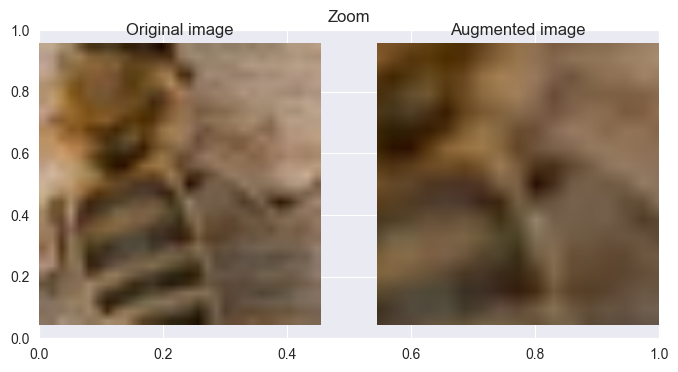

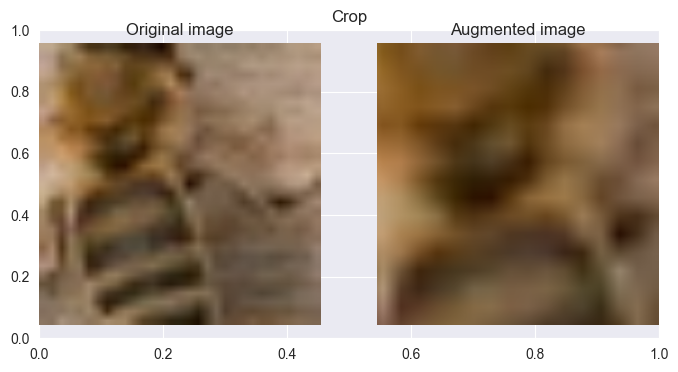

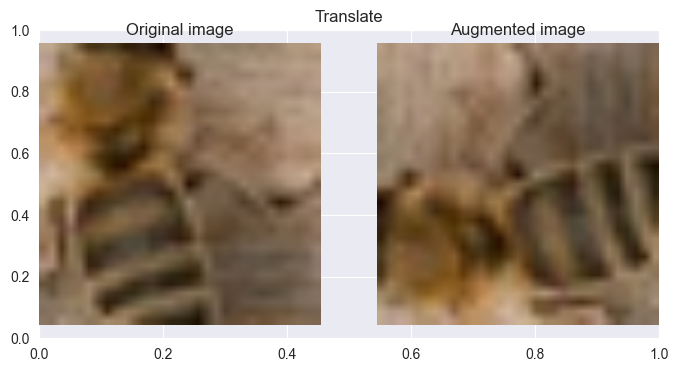

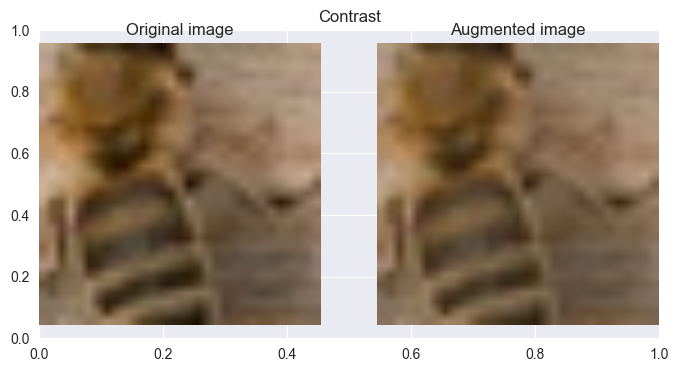

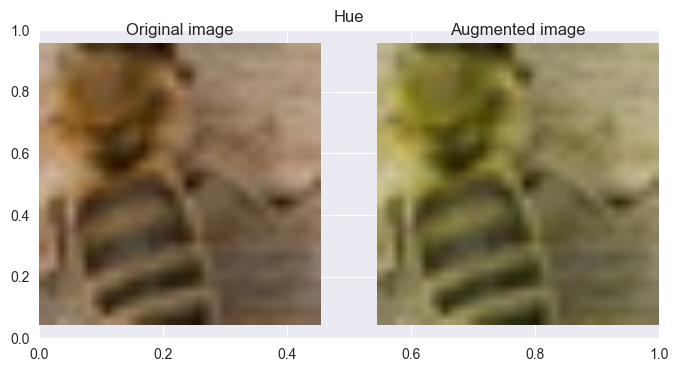

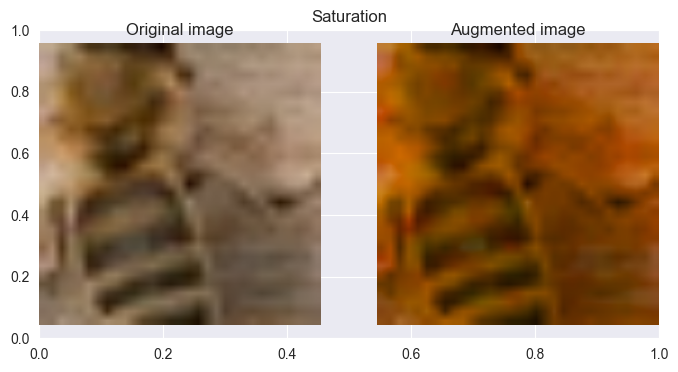

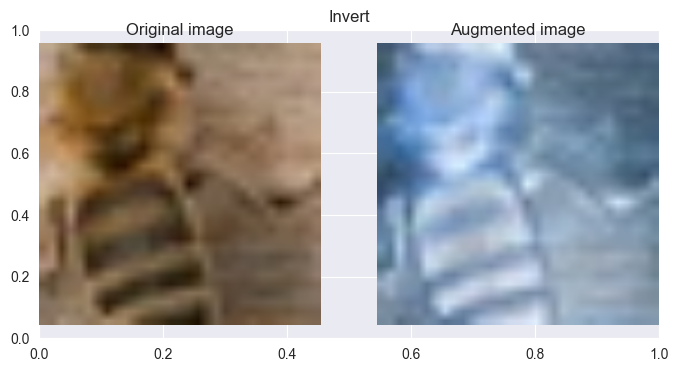

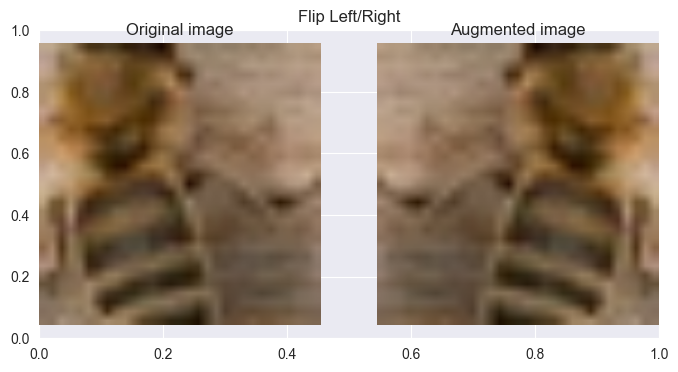

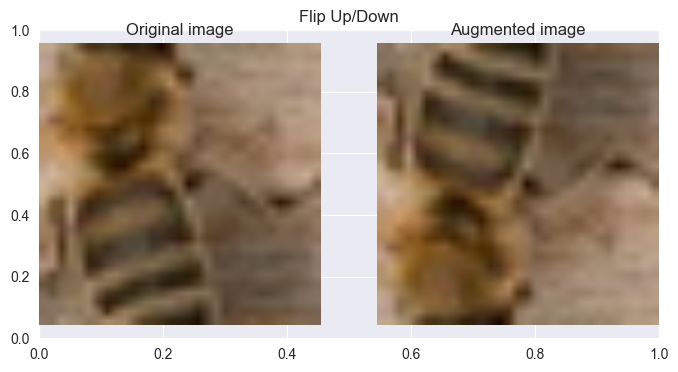

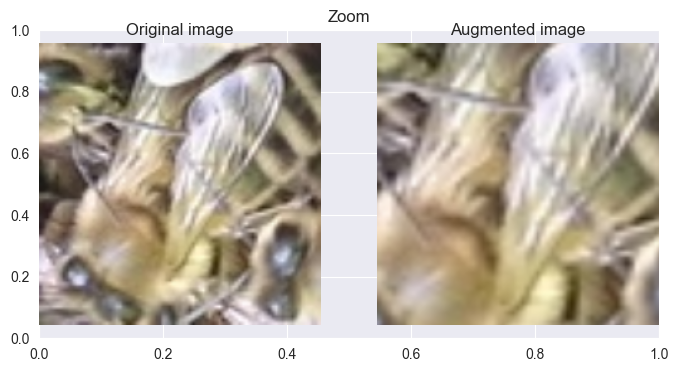

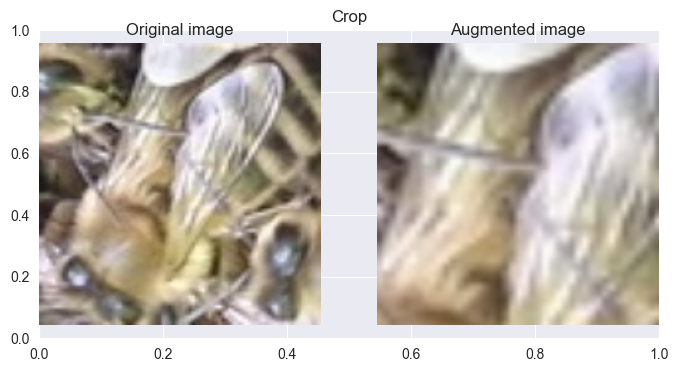

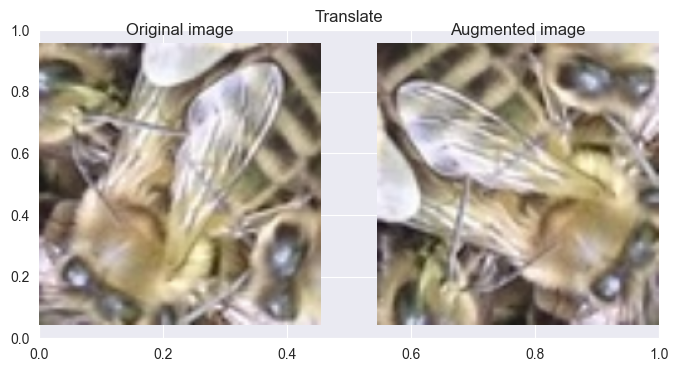

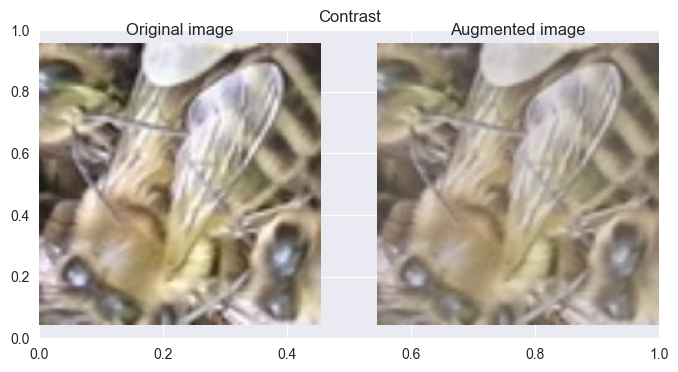

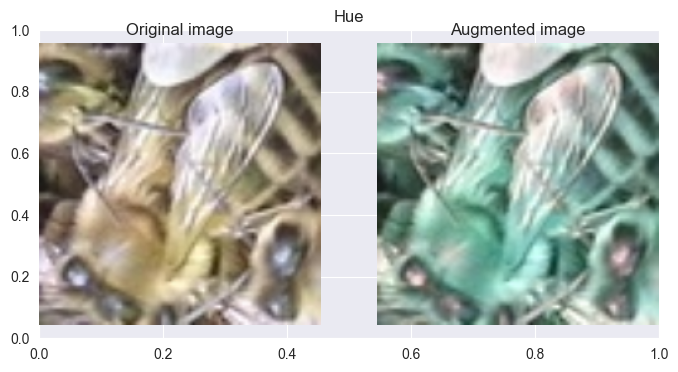

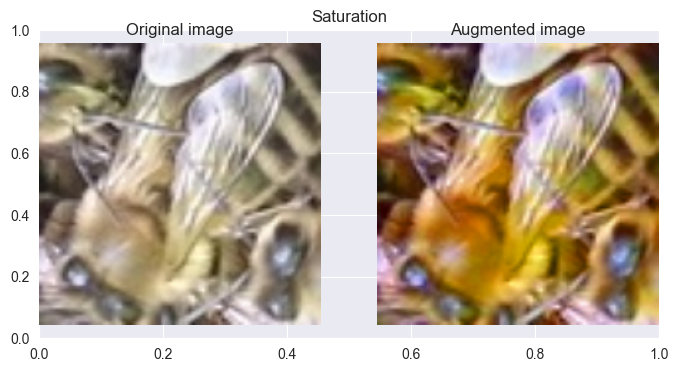

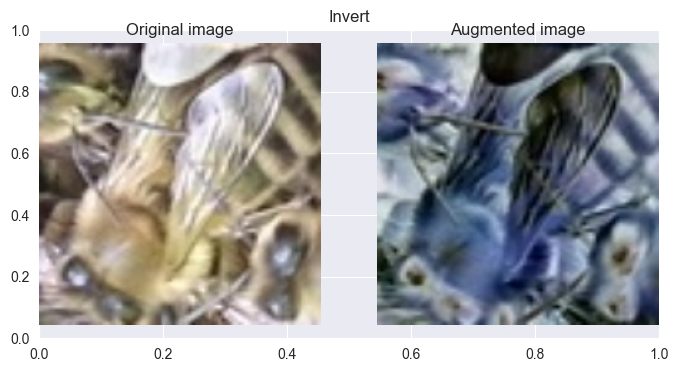

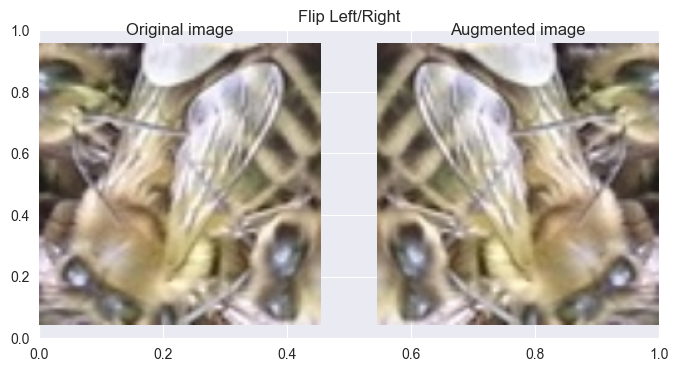

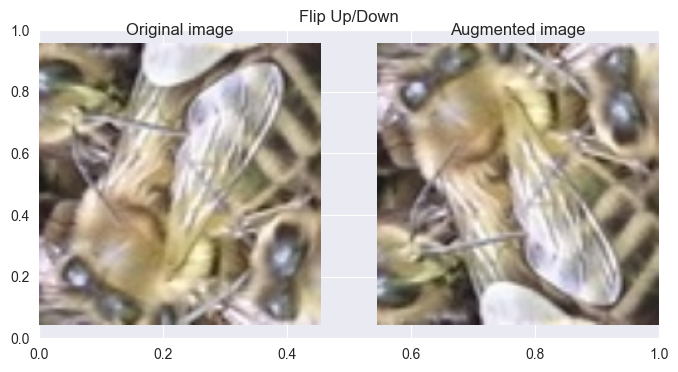

In [31]:
# show augmentation on sample images
img_data = train_ds.unbatch()

for img, label in img_data.take(2):
    image = img
    aug_zoom = zoom_img(image)
    aug_crop = crop_img(image)
    aug_translate = translate_img(image)
    aug_contrast = contrast_img(image)
    aug_hue = change_hue_img(image)
    aug_sat = saturation_img(image)
    aug_invert = invert_img(image)
    aug_lr = flip_lr_img(image)
    aug_ud = flip_ud_img(image)

    visualize(img, aug_zoom, "Zoom")
    visualize(img, aug_crop, "Crop")
    visualize(img, aug_translate, "Translate")
    visualize(img, aug_contrast, "Contrast")
    visualize(img, aug_hue, "Hue")
    visualize(img, aug_sat, "Saturation")
    visualize(img, aug_invert, "Invert")
    visualize(img, aug_lr, "Flip Left/Right")
    visualize(img, aug_ud, "Flip Up/Down")
    

In [32]:
# augment helper function
def apply_augmentation(dataset, aug_fn):
    def augment(image, label):
        image = aug_fn(image)
        return image, label
    return dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
# augment all data, doubles data size
def augment_data_basic(ds, fractions=None):
    if fractions is None:
        fractions = {'zoom': 0.3, 'crop': 0.3, 'translate': 0.3}  # remaining 0.1 will be unaugmented

    # Unbatch dataset to access individual images
    unbatched = ds.unbatch()
    images, labels = [], []

    for img, label in unbatched:
        images.append(img)
        labels.append(label)

    total = len(images)
    idxs = list(range(total))
    random.shuffle(idxs)

    zoom_n = int(fractions['zoom'] * total)
    crop_n = int(fractions['crop'] * total)
    trans_n = int(fractions['translate'] * total)
    remain_n = total - (zoom_n + crop_n + trans_n)

    # Split indices
    zoom_idxs = idxs[:zoom_n]
    crop_idxs = idxs[zoom_n:zoom_n + crop_n]
    trans_idxs = idxs[zoom_n + crop_n:zoom_n + crop_n + trans_n]
    remain_idxs = idxs[zoom_n + crop_n + trans_n:]

    # Augment
    aug_images, aug_labels = [], []
    # add augmented data to unaugmented images
    for i in zoom_idxs:
        images.append(zoom_img(images[i]))
        labels.append(labels[i])

    for i in crop_idxs:
        images.append(crop_img(images[i]))
        labels.append(labels[i])

    for i in trans_idxs:
        images.append(translate_img(images[i]))
        labels.append(labels[i])

    for i in remain_idxs:
        images.append(images[i])
        labels.append(labels[i])

    # Create new dataset
    aug_ds = tf.data.Dataset.from_tensor_slices((images, labels))
    aug_ds = aug_ds.shuffle(1000).batch(batch_size)#.prefetch(tf.data.AUTOTUNE)

    return aug_ds

In [34]:
aug_train_ds = augment_data_basic(train_ds)

In [35]:
# augment only non-bees, increases non-bee size 9x
def augment_data_specific_classes(ds):
    # Unbatch dataset to access individual images
    unbatched = ds.unbatch()
    images, labels = [], []
    aug_images, aug_labels = [], []

    for img, label in unbatched:
        # collect all images
        images.append(img)
        labels.append(label)
        i = tf.argmax(label).numpy() # get index where label == 1 e.g. [0. 0. 1.]
        if class_names[i] != "Bee":  # collect all images that are not bees
            aug_images.append(img)
            aug_labels.append(label)

    total = len(aug_images)
    idxs = list(range(total))

    # just augment images that are not bees, add to all images
    # increases non-bee number x9
    for i in idxs:
        images.append(zoom_img(aug_images[i]))
        labels.append(aug_labels[i])
        
        images.append(crop_img(aug_images[i]))
        labels.append(aug_labels[i])
        
        images.append(translate_img(aug_images[i]))
        labels.append(aug_labels[i])
        
        images.append(contrast_img(aug_images[i]))
        labels.append(aug_labels[i])
        
        images.append(change_hue_img(aug_images[i]))
        labels.append(aug_labels[i])
        
        images.append(saturation_img(aug_images[i]))
        labels.append(aug_labels[i])
        
        images.append(invert_img(aug_images[i]))
        labels.append(aug_labels[i])
        
        images.append(flip_lr_img(aug_images[i]))
        labels.append(aug_labels[i])
        
        images.append(flip_ud_img(aug_images[i]))
        labels.append(aug_labels[i])
        
    # Create new dataset
    aug_ds = tf.data.Dataset.from_tensor_slices((images, labels))
    aug_ds = aug_ds.shuffle(1000).batch(batch_size)#.prefetch(tf.data.AUTOTUNE)

    return aug_ds

In [36]:
aug_train_ds_balanced = augment_data_specific_classes(train_ds)

In [37]:
color_map = {
    'Bee': '#DBC03B',
    'Ant': '#DB5F3B',
    'Bear': '#744d26',
}

def class_distribution(ds, title):
    unbatched = ds.unbatch()
    # extract labels
    l = [label for _, label in unbatched]
    l_ind = [tf.argmax(label).numpy() for label in l]
    # count classes
    class_labels = [class_names[i] for i in l_ind]
    class_dist = dict(Counter(class_labels))
        
    labels = list(class_dist.keys())
    sizes = list(class_dist.values())
    
    colors = [color_map[label] for label in labels]
    
    plt.figure(figsize=(6, 4))
    plt.pie(
        sizes,
        labels=[f"{label} ({count})" for label, count in zip(labels, sizes)],
        colors=colors,
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 10}
    )
    plt.title("Image Count per Class" + title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

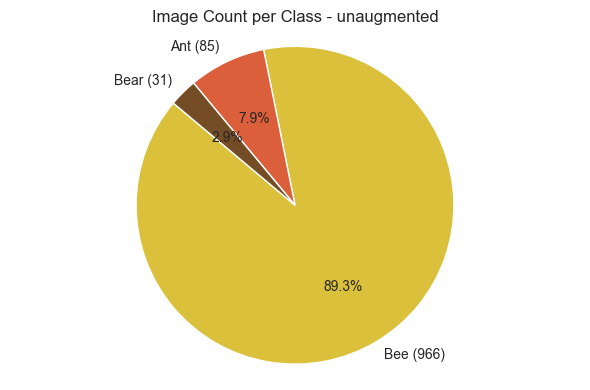

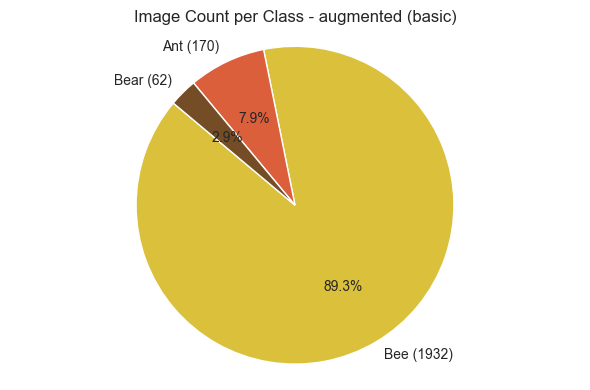

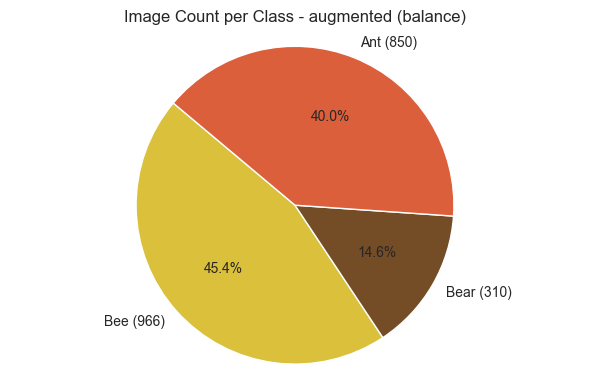

In [38]:
# plot different class distributions to show effects of augmentation
class_distribution(train_ds, " - unaugmented")
class_distribution(aug_train_ds, " - augmented (basic)")
class_distribution(aug_train_ds_balanced, " - augmented (balance)")

### Base Model with basic data augmentation

In [39]:
aug_base_model = ResNet50(include_top=True, weights=None, input_shape=(224, 224, 3), classes=len(class_names)) # include_top=True adds the classification layer

aug_base_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

aug_history = aug_base_model.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.7835 - loss: 1.2787 - val_accuracy: 0.7559 - val_loss: 0.7337
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.8858 - loss: 0.3782 - val_accuracy: 0.9028 - val_loss: 0.4786
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.8907 - loss: 0.3309 - val_accuracy: 0.9028 - val_loss: 0.4163
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.8945 - loss: 0.3655 - val_accuracy: 0.6371 - val_loss: 3.3681
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.8826 - loss: 0.3813 - val_accuracy: 0.7711 - val_loss: 0.4966
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.8917 - loss: 0.2940 - val_accuracy: 0.8661 - val_loss: 0.6106
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.8980 - loss: 0.3079 - val_accuracy: 0.9071 - val_loss: 104.9989
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.8812 - loss: 0.4483 - val_accuracy: 0.2225 -

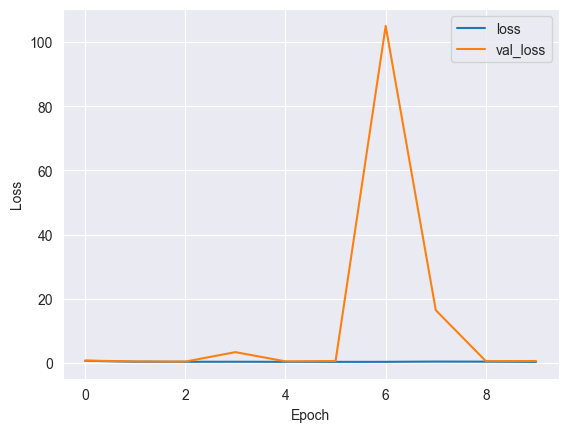

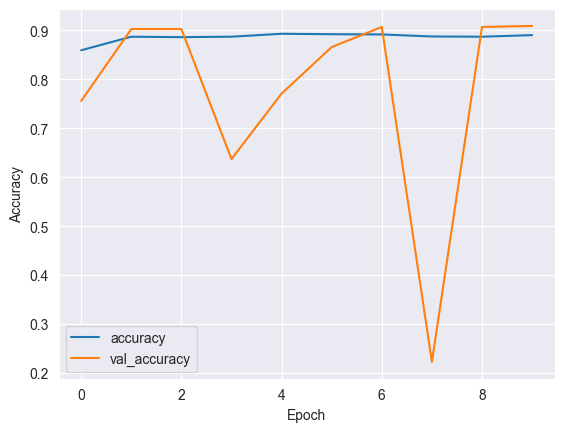

In [40]:
plot_loss(aug_history)
plot_accuracy(aug_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

         Ant       0.00      0.00      0.00        37
        Bear       1.00      0.06      0.11        17
         Bee       0.90      1.00      0.95       463

    accuracy                           0.90       517
   macro avg       0.63      0.35      0.35       517
weighted avg     

C:\Users\Clemens\anaconda3\envs\CV_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Clemens\anaconda3\envs\CV_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Clemens\anaconda3\envs\CV_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

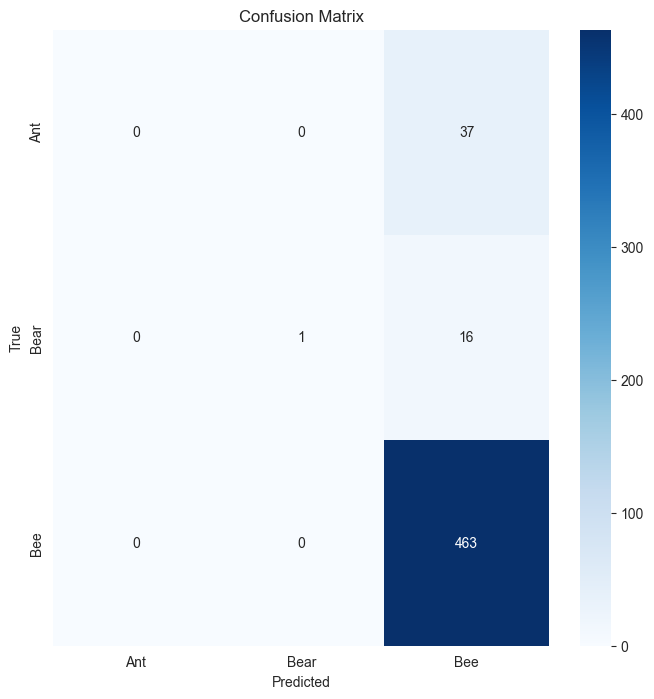

In [41]:
y_true, y_pred = predict_test_data(aug_base_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)
aug_base_model.save('./models/AugPlainResNet50.keras')

### Base Model with balanced data augmentation

In [42]:
aug_bal_base_model = ResNet50(include_top=True, weights=None, input_shape=(224, 224, 3),
                          classes=len(class_names))  # include_top=True adds the classification layer

aug_bal_base_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

aug_bal_history = aug_bal_base_model.fit(
    aug_train_ds_balanced,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.5591 - loss: 1.9326 - val_accuracy: 0.0648 - val_loss: 7808.9380
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.6269 - loss: 0.9824 - val_accuracy: 0.3931 - val_loss: 1.4131
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.6622 - loss: 0.8958 - val_accuracy: 0.4687 - val_loss: 1.5883
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.6140 - loss: 0.9512 - val_accuracy: 0.1598 - val_loss: 1.7210
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.6548 - loss: 0.8366 - val_accuracy: 0.3715 - val_loss: 1.0404
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.6364 - loss: 0.8190 - val_accuracy: 0.4082 - val_loss: 1.0864
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.6387 - loss: 0.8249 - val_accuracy: 0.0497 - val_loss: 3.5812
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.6281 - loss: 0.8712 - val_accuracy: 0.8683 

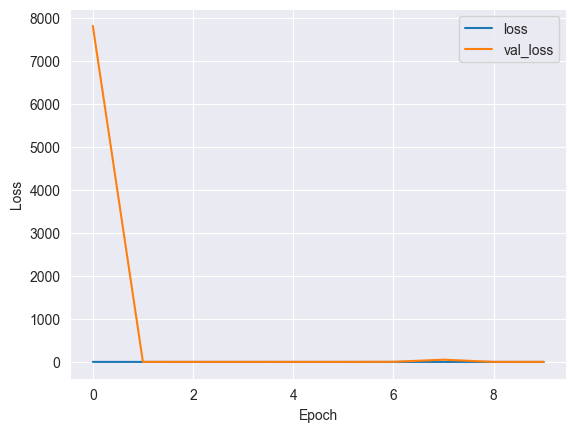

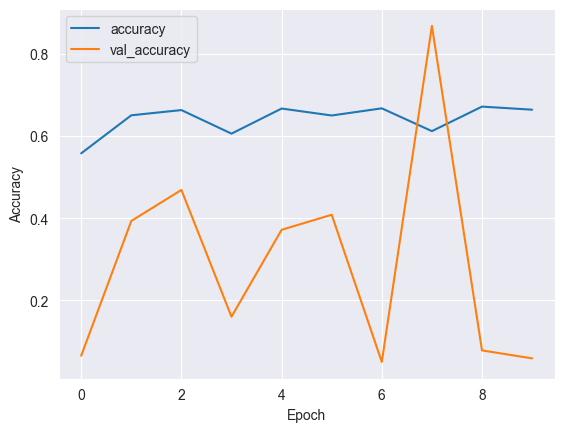

In [43]:
plot_loss(aug_bal_history)
plot_accuracy(aug_bal_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

         Ant       0.11      0.62      0.19        37
        Bear       0.05      0.88      0.09        17
         Bee       1.00      0.01      0.02       463

    accuracy                           0.08       517
   macro avg       0.39      0.50      0.10       517
weighted avg       0.91      0.08      0.03       517



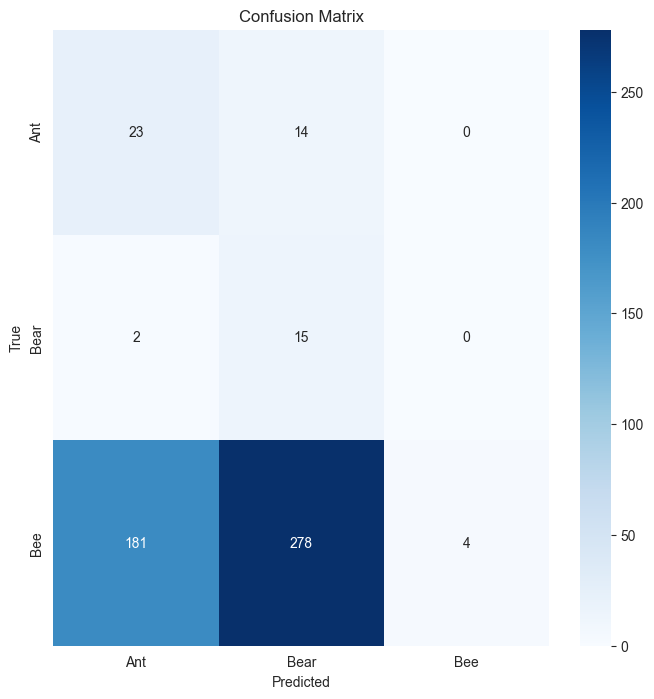

In [44]:
y_true, y_pred = predict_test_data(aug_bal_base_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)
aug_bal_base_model.save('./models/AugBalPlainResNet50.keras')

### Pre-trained model with basic data augmentation

In [45]:
aug_pretrained_model = build_pretrained_model()
aug_pretrained_history = aug_pretrained_model.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.8862 - loss: 0.6426 - val_accuracy: 0.9849 - val_loss: 0.0365
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 800ms/step - accuracy: 0.9921 - loss: 0.0309 - val_accuracy: 0.9870 - val_loss: 0.0350
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 774ms/step - accuracy: 0.9919 - loss: 0.0209 - val_accuracy: 0.9914 - val_loss: 0.0343
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 55s 814ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.9914 - val_loss: 0.0307
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 799ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9892 - val_loss: 0.0324
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 55s 804ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9892 - val_loss: 0.0336
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 56s 824ms/step - accuracy: 1.0000 - loss: 9.8843e-04 - val_accuracy: 0.9914 - val_loss: 0.0317
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 799ms/step - accuracy: 1.0000 - loss: 7.8172e-04 - va

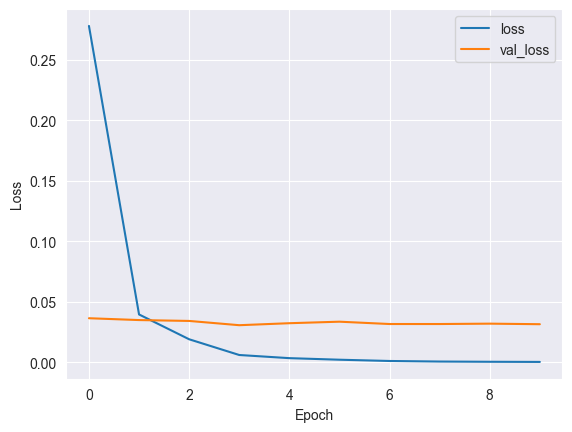

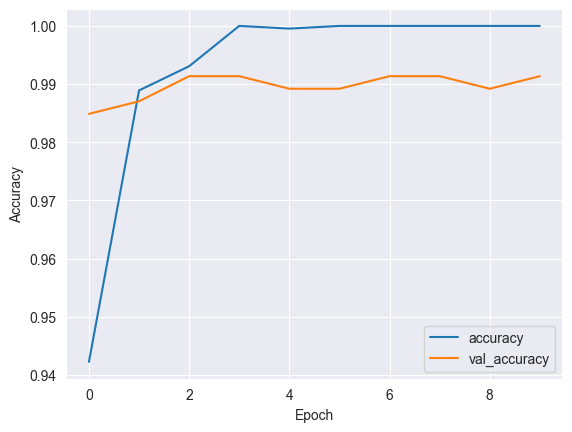

In [46]:
plot_loss(aug_pretrained_history)
plot_accuracy(aug_pretrained_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

         Ant       0.91      0.81      0.86        37
        Bear       0.89      1.00      0.94        17
         Bee       0.98      0.99      0.99       463

    accuracy                           0.98       517
   macro avg       0.93      0.93      0.93       517
weighted avg     

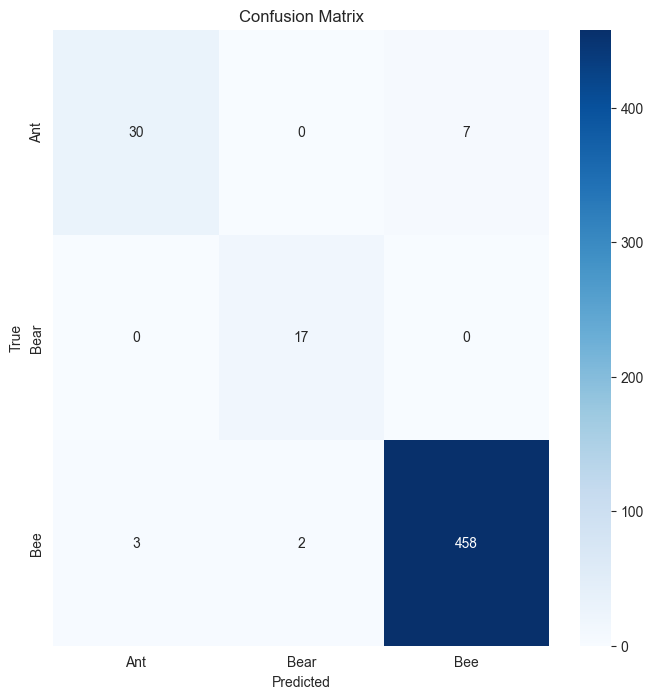

In [47]:
y_true, y_pred = predict_test_data(aug_pretrained_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)
aug_pretrained_model.save('./models/AugPretrainedResNet50.keras')

### Pre-trained model with balanced data augmentation

In [48]:
aug_bal_pretrained_model = build_pretrained_model()
aug_bal_pretrained_history = aug_bal_pretrained_model.fit(
    aug_train_ds_balanced,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 62s 860ms/step - accuracy: 0.8360 - loss: 1.0140 - val_accuracy: 0.9827 - val_loss: 0.0698
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 790ms/step - accuracy: 0.9729 - loss: 0.0759 - val_accuracy: 0.9525 - val_loss: 0.1193
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 785ms/step - accuracy: 0.9757 - loss: 0.0620 - val_accuracy: 0.9762 - val_loss: 0.0746
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 54s 813ms/step - accuracy: 0.9936 - loss: 0.0232 - val_accuracy: 0.9654 - val_loss: 0.1020
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 54s 810ms/step - accuracy: 0.9980 - loss: 0.0148 - val_accuracy: 0.9741 - val_loss: 0.0713
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 54s 801ms/step - accuracy: 0.9998 - loss: 0.0066 - val_accuracy: 0.9914 - val_loss: 0.0314
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 54s 802ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9698 - val_loss: 0.1042
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 54s 800ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accu

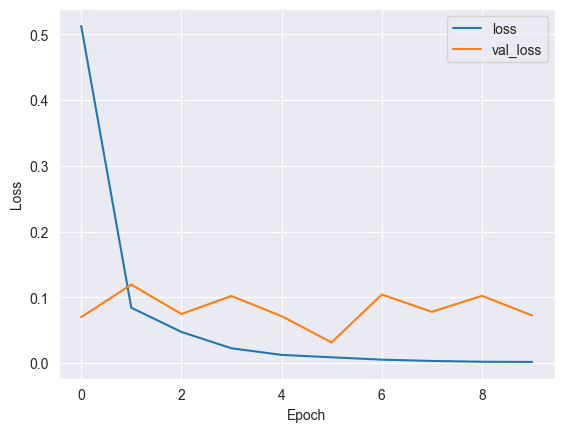

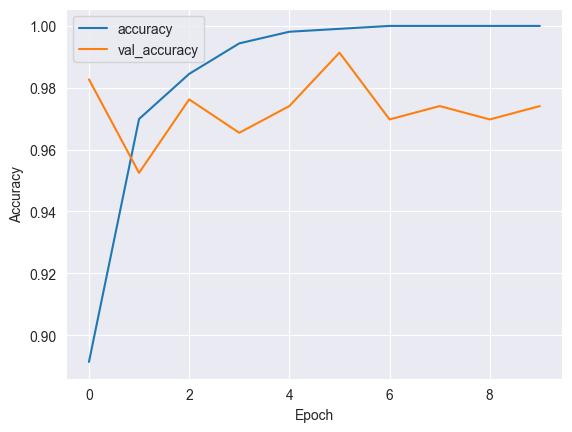

In [49]:
plot_loss(aug_bal_pretrained_history)
plot_accuracy(aug_bal_pretrained_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

         Ant       0.88      0.95      0.91        37
        Bear       0.81      1.00      0.89        17
         Bee       1.00      0.98      0.99       463

    accuracy                           0.98       517
   macro avg       0.89      0.98      0.93       517
weighted avg     

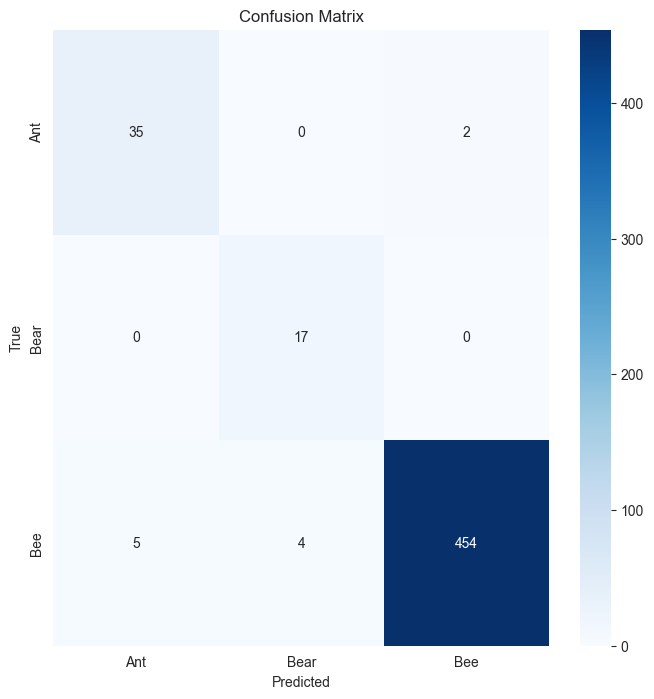

In [50]:
y_true, y_pred = predict_test_data(aug_bal_pretrained_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)
aug_bal_pretrained_model.save('./models/AugBalPretrainedResNet50.keras')

# Custom architecture

In [51]:
def build_custom_model():
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Freezing conv1 layers and earlier so that they don't update (acts like a feature extractor)
    for layer in base.layers:
        if 'conv1' in layer.name:
            layer.trainable = False

    x = base.get_layer('conv3_block4_out').output

    # Inception module (process features at multiple receptive fields)
    path1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x)

    path2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(128, (3, 3), padding='same', activation='relu')(path2)

    path3 = Conv2D(128, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(128, (5, 5), padding='same', activation='relu')(path3)

    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(128, (1, 1), padding='same', activation='relu')(path4)

    inception = Concatenate()([path1, path2, path3, path4])

    # Adding 1x1 convolutional layer
    x = layers.Conv2D(1024, (1, 1), padding='valid', strides=1, activation=tf.nn.leaky_relu)(inception)

    # Adding 3x3 convolutional layer
    x = layers.Conv2D(1024, (3, 3), padding='same', strides=2, activation=tf.nn.leaky_relu)(x)

    # Adding global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(3, activation='softmax')(x)

    # final model
    model = Model(inputs=base.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [52]:
custom_model = build_custom_model()
custom_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_9[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 12,246,659 (46.72 MB)

 Trainable params: 12,226,947 (46.64 MB)

 Non-trainable params: 19,712 (77.00 KB)

### Custom model with original data

In [53]:
orig_custom_history = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.8183 - loss: 4.9763 - val_accuracy: 0.9071 - val_loss: 6.4477
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.8938 - loss: 0.4579 - val_accuracy: 0.9071 - val_loss: 38.4656
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9137 - loss: 0.2900 - val_accuracy: 0.9136 - val_loss: 1.0768
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.9276 - loss: 0.2227 - val_accuracy: 0.9114 - val_loss: 0.3420
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.9397 - loss: 0.2086 - val_accuracy: 0.8769 - val_loss: 0.5303
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.9547 - loss: 0.1272 - val_accuracy: 0.9374 - val_loss: 0.2168
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9664 - loss: 0.1117 - val_accuracy: 0.9330 - val_loss: 0.2586
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.9621 - loss: 0.1019 - val_accuracy: 0.9352 - v

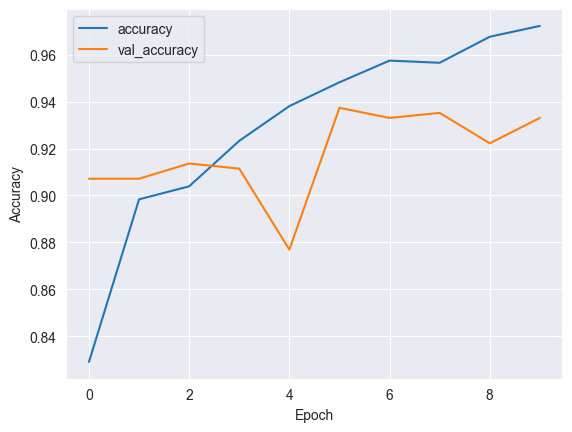

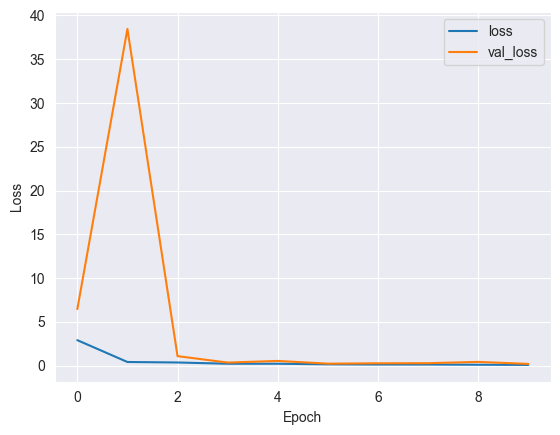

In [54]:
plot_accuracy(orig_custom_history)
plot_loss(orig_custom_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
              precision    recall  f1-score   support

         Ant       0.56      0.73      0.64        37
        Bear       0.71      1.00      0.83        17
         Bee       0.98      0.95      0.96       463

    accuracy                           0.93       517
   macro avg       0.75      0.89      0.81       517
weighted avg  

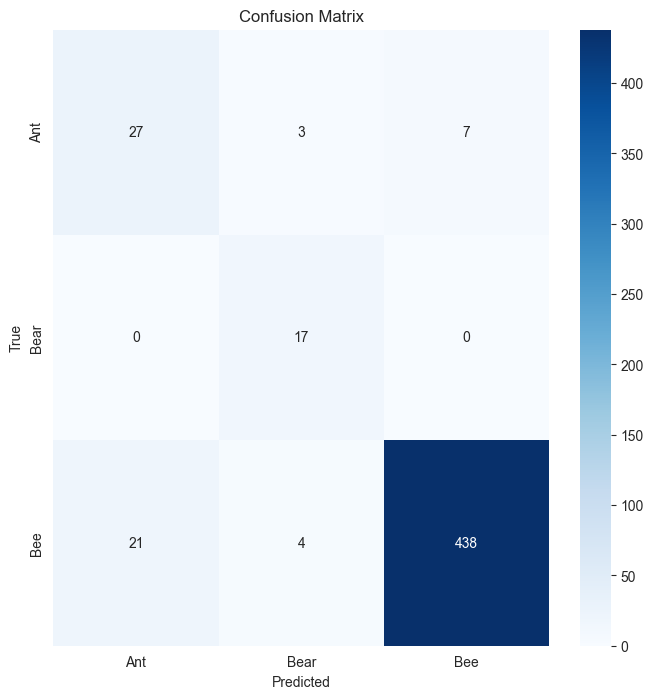

In [55]:
y_true, y_pred = predict_test_data(custom_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)

### Custom model with basic data augmentation

In [56]:
aug_custom_model = build_custom_model()

aug_custom_history = aug_custom_model.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.7626 - loss: 3.9813 - val_accuracy: 0.9222 - val_loss: 0.2775
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.9073 - loss: 0.2427 - val_accuracy: 0.7797 - val_loss: 0.9765
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9330 - loss: 0.2112 - val_accuracy: 0.9158 - val_loss: 0.4481
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9556 - loss: 0.1329 - val_accuracy: 0.9158 - val_loss: 0.2380
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9577 - loss: 0.1357 - val_accuracy: 0.9395 - val_loss: 0.4493
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9716 - loss: 0.0942 - val_accuracy: 0.9438 - val_loss: 0.3117
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.9694 - loss: 0.0771 - val_accuracy: 0.9633 - val_loss: 0.1482
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.9805 - loss: 0.0602 - val_accuracy: 0.9201 - v

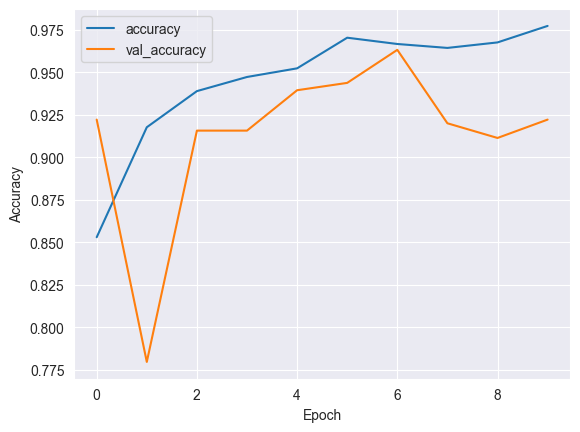

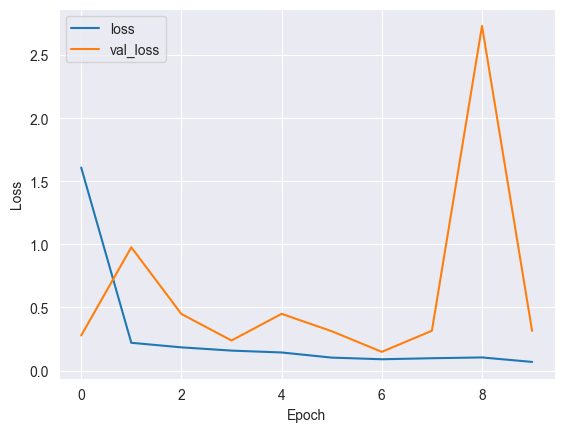

In [57]:
plot_accuracy(aug_custom_history)
plot_loss(aug_custom_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
              precision    recall  f1-score   support

         Ant       0.89      0.22      0.35        37
        Bear       0.40      0.94      0.56        17
         Bee       0.96      0.97      0.96       463

    accuracy                           0.91       517
   macro avg       0.75      0.71      0.62       517
weighted av

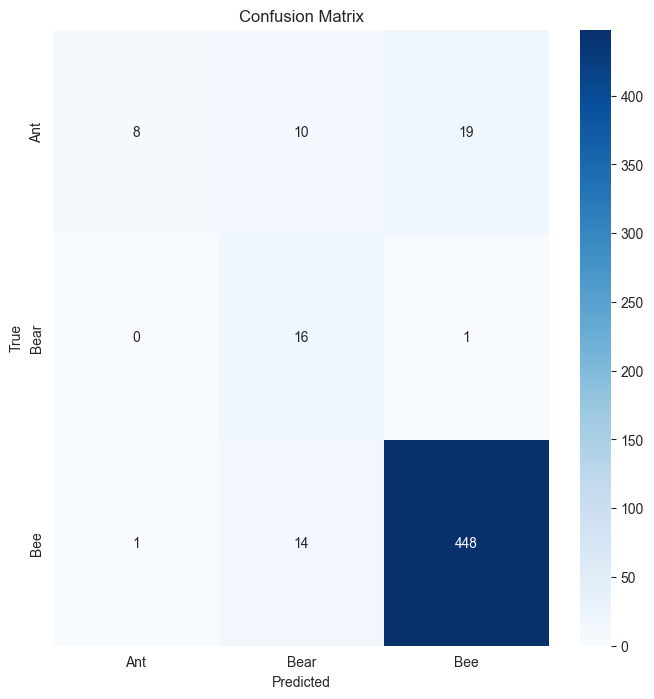

In [58]:
y_true, y_pred = predict_test_data(aug_custom_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)

### Custom model with balanced data augmentation

In [59]:
aug_bal_custom_model = build_custom_model()

aug_bal_custom_history = aug_bal_custom_model.fit(
    aug_train_ds_balanced,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.6479 - loss: 4.5811 - val_accuracy: 0.1317 - val_loss: 5.4804
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.7427 - loss: 0.6195 - val_accuracy: 0.8423 - val_loss: 0.3928
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.7893 - loss: 0.5255 - val_accuracy: 0.8790 - val_loss: 0.3401
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.8086 - loss: 0.4790 - val_accuracy: 0.3348 - val_loss: 2.1460
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.8155 - loss: 0.4467 - val_accuracy: 0.9006 - val_loss: 0.3516
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.8293 - loss: 0.4478 - val_accuracy: 0.1965 - val_loss: 5.5108
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.8393 - loss: 0.4016 - val_accuracy: 0.8294 - val_loss: 0.4145
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.8364 - loss: 0.4171 - val_accuracy: 0.6652 - v

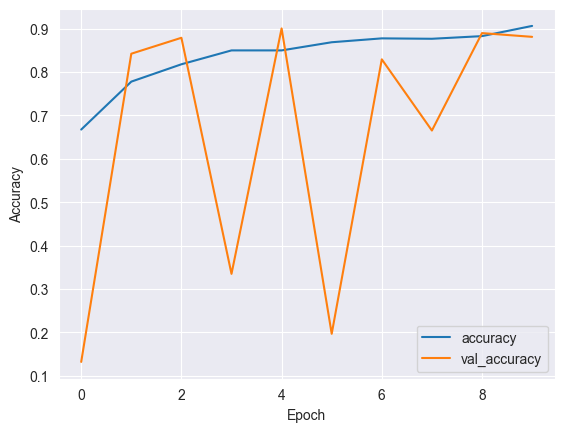

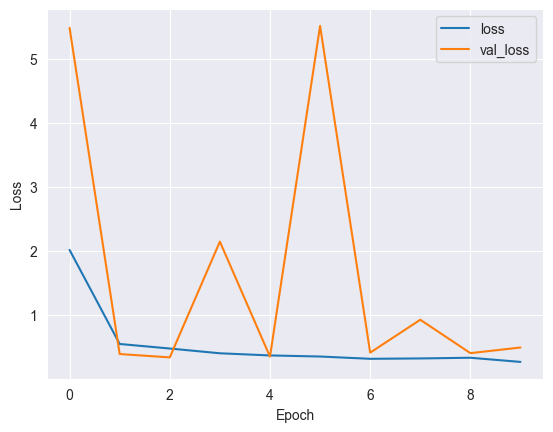

In [60]:
plot_accuracy(aug_bal_custom_history)
plot_loss(aug_bal_custom_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
              precision    recall  f1-score   support

         Ant       0.41      0.65      0.50        37
        Bear       1.00      0.53      0.69        17
         Bee       0.96      0.94      0.95       463

    accuracy                           0.90       517
   macro avg       0.79      0.70      0.71       517
weighted av

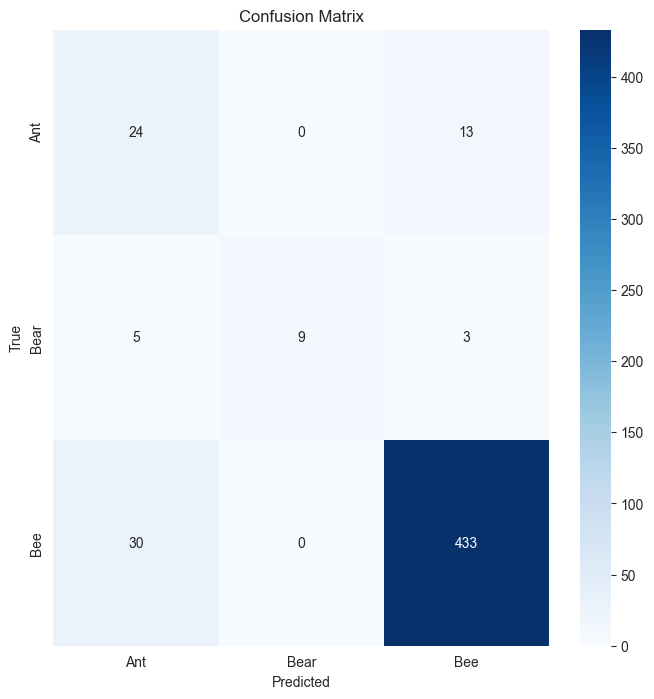

In [61]:
y_true, y_pred = predict_test_data(aug_bal_custom_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)

### Test all trained models on custom data not in the train dataset

In [67]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [72]:
MODEL_DIR = 'models'
DATA_DIR = 'custom_data'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [89]:
import os

root_dir = 'custom_data'
classes = ['bee', 'ant', 'bear']

# Step 1: Temporarily rename to avoid name clashes
for class_name in classes:
    class_path = os.path.join(root_dir, class_name)
    image_files = [f for f in sorted(os.listdir(class_path)) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for idx, filename in enumerate(image_files):
        old_path = os.path.join(class_path, filename)
        temp_path = os.path.join(class_path, f"temp_{idx}.tmp")
        os.rename(old_path, temp_path)

# Step 2: Rename from temp files to final names
for class_name in classes:
    class_path = os.path.join(root_dir, class_name)
    temp_files = [f for f in sorted(os.listdir(class_path)) if f.startswith("temp_")]
    
    for idx, filename in enumerate(temp_files, start=1):
        ext = '.jpg'  # Set default extension if needed
        final_name = f"{class_name}{idx}{ext}"
        temp_path = os.path.join(class_path, filename)
        final_path = os.path.join(class_path, final_name)
        os.rename(temp_path, final_path)
        print(f"✅ Renamed: {temp_path} → {final_path}")


✅ Renamed: custom_data\bee\temp_0.tmp → custom_data\bee\bee1.jpg
✅ Renamed: custom_data\bee\temp_1.tmp → custom_data\bee\bee2.jpg
✅ Renamed: custom_data\bee\temp_10.tmp → custom_data\bee\bee3.jpg
✅ Renamed: custom_data\bee\temp_11.tmp → custom_data\bee\bee4.jpg
✅ Renamed: custom_data\bee\temp_12.tmp → custom_data\bee\bee5.jpg
✅ Renamed: custom_data\bee\temp_13.tmp → custom_data\bee\bee6.jpg
✅ Renamed: custom_data\bee\temp_14.tmp → custom_data\bee\bee7.jpg
✅ Renamed: custom_data\bee\temp_15.tmp → custom_data\bee\bee8.jpg
✅ Renamed: custom_data\bee\temp_16.tmp → custom_data\bee\bee9.jpg
✅ Renamed: custom_data\bee\temp_17.tmp → custom_data\bee\bee10.jpg
✅ Renamed: custom_data\bee\temp_18.tmp → custom_data\bee\bee11.jpg
✅ Renamed: custom_data\bee\temp_19.tmp → custom_data\bee\bee12.jpg
✅ Renamed: custom_data\bee\temp_2.tmp → custom_data\bee\bee13.jpg
✅ Renamed: custom_data\bee\temp_20.tmp → custom_data\bee\bee14.jpg
✅ Renamed: custom_data\bee\temp_21.tmp → custom_data\bee\bee15.jpg
✅ Renam

In [90]:
custom_data = image_dataset_from_directory(
    DATA_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False  # Don't shuffle so evaluation is consistent
)
class_names = custom_data.class_names
print("Class names:", class_names)

Found 90 files belonging to 3 classes.
Class names: ['ant', 'bear', 'bee']


In [91]:
model_files = [f for f in os.listdir(MODEL_DIR) if f.endswith(('.h5', '.keras'))]
model_paths = [os.path.join(MODEL_DIR, f) for f in model_files]

In [92]:
from PIL import Image
import os

root_dir = "custom_data"

for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)
        try:
            with Image.open(file_path) as img:
                print(f"{file_path} → Format: {img.format}")
        except Exception as e:
            print(f"❌ Couldn't open {file_path}: {e}")


custom_data\ant\ant1.jpg → Format: JPEG
custom_data\ant\ant10.jpg → Format: JPEG
custom_data\ant\ant11.jpg → Format: JPEG
custom_data\ant\ant12.jpg → Format: JPEG
custom_data\ant\ant13.jpg → Format: JPEG
custom_data\ant\ant14.jpg → Format: JPEG
custom_data\ant\ant15.jpg → Format: JPEG
custom_data\ant\ant16.jpg → Format: JPEG
custom_data\ant\ant17.jpg → Format: JPEG
custom_data\ant\ant18.jpg → Format: JPEG
custom_data\ant\ant19.jpg → Format: JPEG
custom_data\ant\ant2.jpg → Format: JPEG
custom_data\ant\ant20.jpg → Format: JPEG
custom_data\ant\ant21.jpg → Format: JPEG
custom_data\ant\ant22.jpg → Format: JPEG
custom_data\ant\ant23.jpg → Format: JPEG
custom_data\ant\ant24.jpg → Format: JPEG
custom_data\ant\ant25.jpg → Format: JPEG
custom_data\ant\ant26.jpg → Format: JPEG
custom_data\ant\ant27.jpg → Format: JPEG
custom_data\ant\ant28.jpg → Format: JPEG
custom_data\ant\ant29.jpg → Format: JPEG
custom_data\ant\ant3.jpg → Format: JPEG
custom_data\ant\ant30.jpg → Format: JPEG
custom_data\ant\ant

In [93]:
# Prepare the full dataset as arrays
all_images = []
all_labels = []

for images, labels in custom_data:
    all_images.append(images)
    all_labels.append(labels)

x_all = tf.concat(all_images, axis=0)
y_true = tf.concat(all_labels, axis=0).numpy()

In [94]:
results = []


 Evaluating models\AugBalPlainResNet50.keras...
Confusion Matrix:
[[16 14  0]
 [16 14  0]
 [15 15  0]]

Classification Report:
              precision    recall  f1-score   support

         ant       0.34      0.53      0.42        30
        bear       0.33      0.47      0.38        30
         bee       0.00      0.00      0.00        30

    accuracy                           0.33        90
   macro avg       0.22      0.33      0.27        90
weighted avg       0.22      0.33      0.27        90



C:\Users\Clemens\anaconda3\envs\CV_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Clemens\anaconda3\envs\CV_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Clemens\anaconda3\envs\CV_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

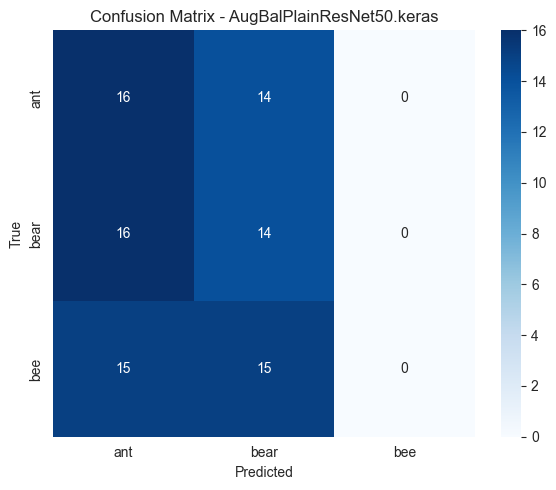


 Evaluating models\AugBalPretrainedResNet50.keras...
Confusion Matrix:
[[25  0  5]
 [ 0 30  0]
 [ 1  0 29]]

Classification Report:
              precision    recall  f1-score   support

         ant       0.96      0.83      0.89        30
        bear       1.00      1.00      1.00        30
         bee       0.85      0.97      0.91        30

    accuracy                           0.93        90
   macro avg       0.94      0.93      0.93        90
weighted avg       0.94      0.93      0.93        90



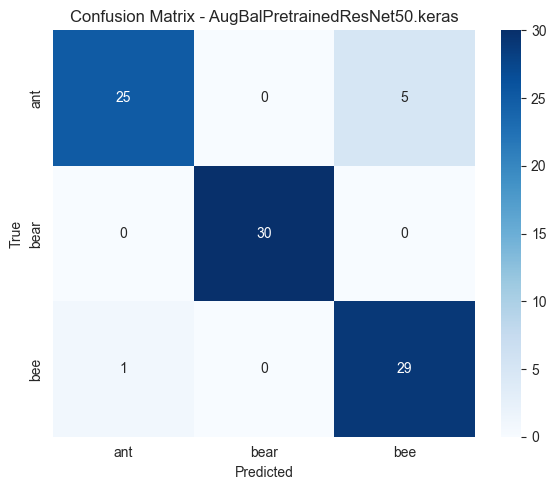


 Evaluating models\AugPlainResNet50.keras...
Confusion Matrix:
[[ 0  0 30]
 [ 0  0 30]
 [ 0  0 30]]

Classification Report:
              precision    recall  f1-score   support

         ant       0.00      0.00      0.00        30
        bear       0.00      0.00      0.00        30
         bee       0.33      1.00      0.50        30

    accuracy                           0.33        90
   macro avg       0.11      0.33      0.17        90
weighted avg       0.11      0.33      0.17        90



C:\Users\Clemens\anaconda3\envs\CV_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Clemens\anaconda3\envs\CV_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Clemens\anaconda3\envs\CV_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

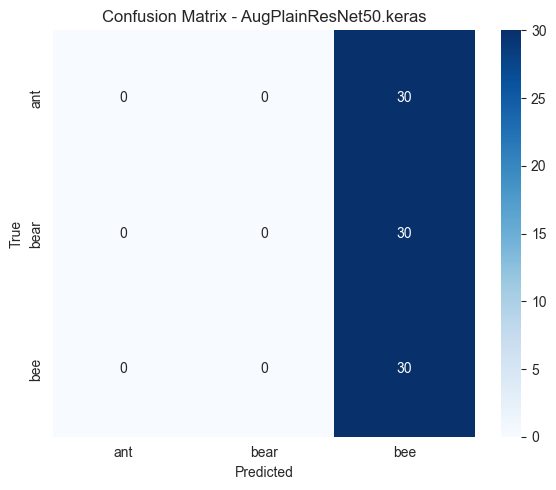


 Evaluating models\AugPretrainedResNet50.keras...
Confusion Matrix:
[[26  0  4]
 [ 0 30  0]
 [ 0  0 30]]

Classification Report:
              precision    recall  f1-score   support

         ant       1.00      0.87      0.93        30
        bear       1.00      1.00      1.00        30
         bee       0.88      1.00      0.94        30

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90



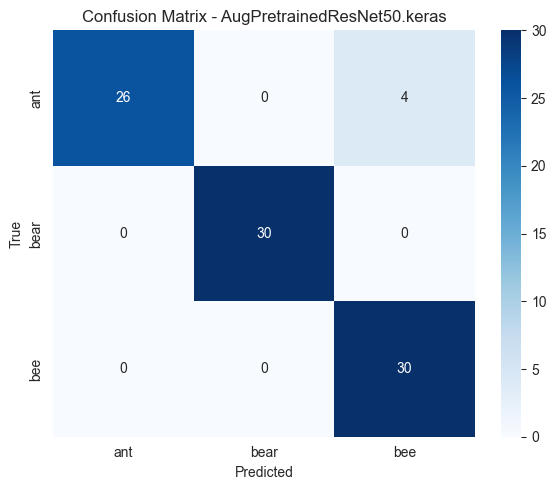


 Evaluating models\PlainResNet50.keras...
Confusion Matrix:
[[ 3  0 27]
 [ 1  1 28]
 [ 3  1 26]]

Classification Report:
              precision    recall  f1-score   support

         ant       0.43      0.10      0.16        30
        bear       0.50      0.03      0.06        30
         bee       0.32      0.87      0.47        30

    accuracy                           0.33        90
   macro avg       0.42      0.33      0.23        90
weighted avg       0.42      0.33      0.23        90



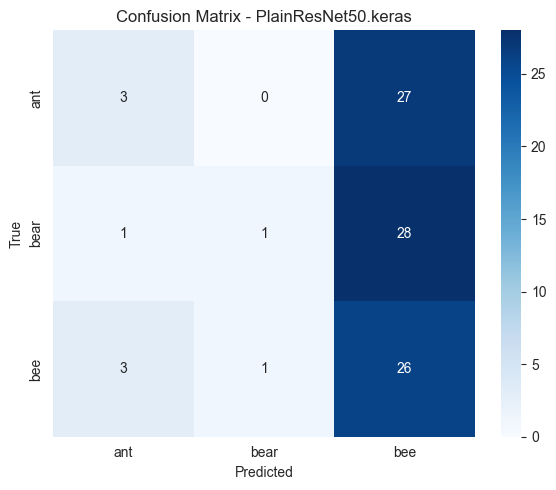


 Evaluating models\PretrainedResNet50.keras...
Confusion Matrix:
[[25  0  5]
 [ 0 30  0]
 [ 0  0 30]]

Classification Report:
              precision    recall  f1-score   support

         ant       1.00      0.83      0.91        30
        bear       1.00      1.00      1.00        30
         bee       0.86      1.00      0.92        30

    accuracy                           0.94        90
   macro avg       0.95      0.94      0.94        90
weighted avg       0.95      0.94      0.94        90



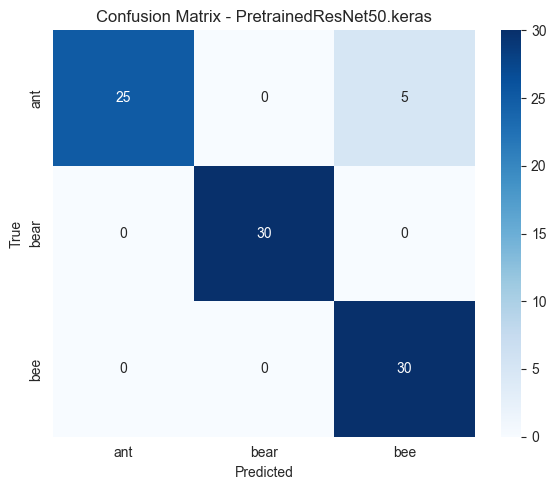

In [96]:
for model_path in model_paths:
    print(f"\n Evaluating {model_path}...")
    model = load_model(model_path)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    # Accuracy and loss
    loss, acc = model.evaluate(custom_data, verbose=0)

    # Predictions
    y_pred_probs = model.predict(x_all, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {os.path.basename(model_path)}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Store overall result
    results.append({
        'Model': os.path.basename(model_path),
        'Loss': loss,
        'Accuracy': acc
    })

In [97]:
df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\n Model Comparison Summary:")
print(df.to_string(index=False))


 Model Comparison Summary:
                         Model     Loss  Accuracy
   AugPretrainedResNet50.keras 0.332676  0.955556
      PretrainedResNet50.keras 0.254505  0.944444
AugBalPretrainedResNet50.keras 0.252806  0.933333
     AugBalPlainResNet50.keras 1.541461  0.333333
        AugPlainResNet50.keras 4.675501  0.333333
           PlainResNet50.keras 2.765162  0.333333
